In [3]:
pwd

'/mnt/storage/Shrey/PDAC_Downstream'

In [4]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import os

In [ ]:
adata = ad.read_zarr('/mnt/ssd/atlases/Human_Atlas_Harmonised.zarr/')
malignant = adata[adata.obs['Level_3'].str.startswith('Malignant')]
malignant.obs['Dataset_ID'] = malignant.obs.Dataset.astype(str) + '_' + malignant.obs.Sample_ID.astype(str)
composition = pd.crosstab(malignant.obs['Dataset_ID'], malignant.obs['Level_4'])
composition_prop = composition.div(composition.sum(axis=1), axis=0) * 100

In [ ]:
ps_adata = ad.AnnData(X=composition_prop.values.copy(), obs=composition_prop.index.to_frame(index=False), var=pd.DataFrame(index=composition_prop.columns))
patient_meta = malignant.obs[['Dataset_ID', 'Dataset', 'Technology', 'Treatment', 'TreatmentType']].drop_duplicates(subset='Dataset_ID')
patient_meta = patient_meta.set_index('Dataset_ID')
ps_adata.obs = ps_adata.obs.set_index('Dataset_ID').join(patient_meta, how='left')
ps_adata.obs.index.name = None  
ps_adata.obs = ps_adata.obs.astype(str)
ps_adata.obs.reset_index(inplace=True)
ps_adata.obs.rename(columns={'index':'Dataset_ID'}, inplace=True)

In [ ]:
# remove schalk and carpenter
ps_adata = ps_adata[~ps_adata.obs.Dataset.isin(['Carpenter_2023', 'Schalck_2022'])]

In [ ]:
ps_adata

In [22]:
sc.pp.pca(ps_adata)
sc.pp.neighbors(ps_adata, metric='cosine', n_neighbors=20)
sc.tl.umap(ps_adata)
sc.tl.leiden(ps_adata, resolution=1)

/home/shrey/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/home/shrey/miniconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


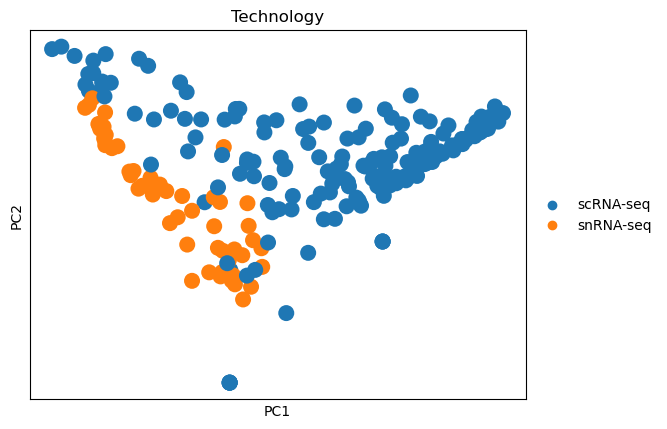

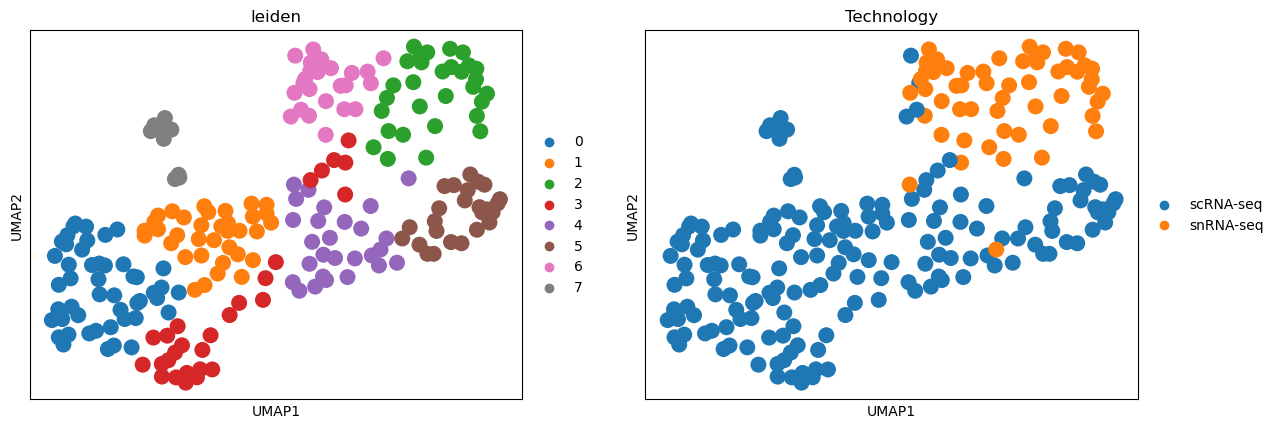

In [23]:
sc.pl.pca(ps_adata, color='Technology')
sc.pl.umap(ps_adata, color=['leiden', 'Technology'])

In [24]:
# combat correct
ps_adata.layers['pre_combat'] = ps_adata.X.copy()
sc.pp.combat(ps_adata, key='Technology')

In [32]:
sc.pp.pca(ps_adata)
sc.pp.neighbors(ps_adata, metric='cosine', n_neighbors=20)
sc.tl.umap(ps_adata)
sc.tl.leiden(ps_adata, resolution=0.5)

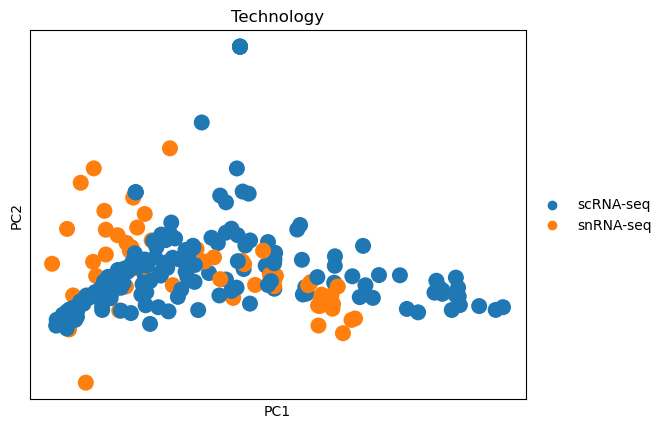

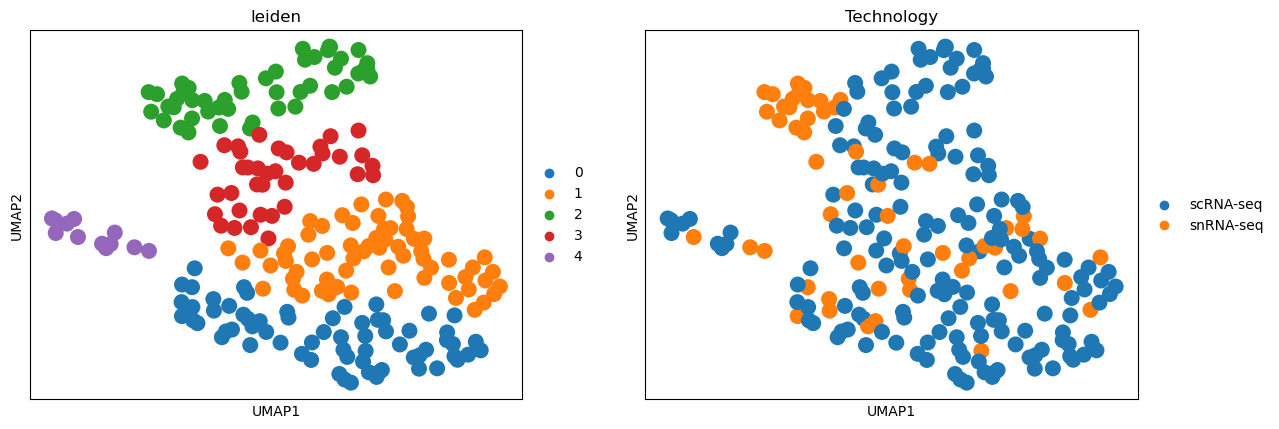

In [34]:
sc.pl.pca(ps_adata, color='Technology')
sc.pl.umap(ps_adata, color=['leiden', 'Technology'])

In [35]:
ps_adata.write('ps_adata.h5ad')

# Add Leiden back

In [36]:
adata.obs['Dataset_ID'] = adata.obs.Dataset.astype(str) + '_' + adata.obs.Sample_ID.astype(str)
adata.obs['Patient_Cluster'] = adata.obs.Dataset_ID.map(dict(zip(ps_adata.obs.Dataset_ID, 'Patient_Cluster_' + ps_adata.obs.leiden.astype(str))))

# Create ps_bulk_adata

In [39]:
malignant = adata[adata.obs['Level_3'].str.startswith('Malignant')]

In [40]:
sc.pp.filter_genes(malignant, min_cells=10)

/home/shrey/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [41]:
malignant.var["mt"] = malignant.var_names.str.startswith("MT-")
malignant.var["ribo"] = malignant.var_names.str.startswith(("RPS", "RPL"))
malignant.var["hb"] = malignant.var_names.str.contains("^HB[^(P)]")

In [42]:
genes_to_remove = malignant.var["mt"] | malignant.var["ribo"] | malignant.var["hb"]
malignant_filtered = malignant[:, ~genes_to_remove]

In [43]:
X = pd.DataFrame(malignant_filtered.layers['log_norm'].toarray(), index=malignant_filtered.obs_names, columns=malignant_filtered.var_names)
X['Dataset_ID'] = malignant_filtered.obs['Dataset_ID'].values
pseudobulk = X.groupby('Dataset_ID').mean()

In [52]:
ps_bulk_adata = ad.AnnData(
    X=pseudobulk.values,
    obs=pd.DataFrame(index=pseudobulk.index),  # patients
    var=pd.DataFrame(index=pseudobulk.columns)  # genes
)

In [53]:
# patient metadata
patient_meta = malignant_filtered.obs[['Dataset_ID', 'Dataset', 'Technology', 'Treatment', 'TreatmentType', 'Patient_Cluster']].drop_duplicates(subset='Dataset_ID')
patient_meta = patient_meta.set_index('Dataset_ID')
ps_bulk_adata.obs = ps_bulk_adata.obs.join(patient_meta, how='left')

In [55]:
ps_bulk_adata = ps_bulk_adata[ps_bulk_adata.obs_names.isin(ps_adata.obs.Dataset_ID)]

In [56]:
ps_bulk_adata

View of AnnData object with n_obs × n_vars = 226 × 36220
    obs: 'Dataset', 'Technology', 'Treatment', 'TreatmentType', 'Patient_Cluster'

In [57]:
np.median(ps_bulk_adata.X)  # If values are around 0–10, likely log-normalized

array(0.)

In [58]:
ps_adata

AnnData object with n_obs × n_vars = 226 × 10
    obs: 'Dataset_ID', 'Dataset', 'Technology', 'Treatment', 'TreatmentType', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'Technology_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'pre_combat'
    obsp: 'distances', 'connectivities'

In [59]:
ps_bulk_adata

View of AnnData object with n_obs × n_vars = 226 × 36220
    obs: 'Dataset', 'Technology', 'Treatment', 'TreatmentType', 'Patient_Cluster'

In [17]:
sc.pp.pca(ps_adata)
sc.pl.pca(ps_adata, color=['Technology', 'leiden'], components=['1,2', '2,3'], wspace=0.5)

In [17]:
sc.pp.neighbors(ps_adata, metric='cosine', n_neighbors=30)

/home/shrey/miniconda3/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [136]:
sc.tl.leiden(ps_adata, resolution=0.55)
sc.tl.umap(ps_adata)

In [137]:
del ps_adata.uns['leiden_colors']

In [138]:
sc.pl.umap(ps_adata, color=['Technology', 'leiden'], wspace=0.5)

# Trajectories

In [21]:
ps_adata

AnnData object with n_obs × n_vars = 243 × 10
    obs: 'Dataset_ID', 'leiden', 'Dataset', 'Technology', 'Treatment', 'TreatmentType', 'dpt_pseudotime', 'is_root'
    uns: 'Dataset_colors', 'Technology_colors', 'TreatmentType_colors', 'Treatment_colors', 'dendrogram_leiden', 'diffmap_evals', 'iroot', 'is_root_colors', 'leiden', 'neighbors', 'pca', 'umap', 'leiden_colors'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [22]:
ps_bulk_adata

AnnData object with n_obs × n_vars = 243 × 36220
    obs: 'Dataset', 'Technology', 'Treatment', 'TreatmentType', 'Patient_Cluster'
    uns: 'Patient_Cluster_DGE', 'Patient_Cluster_colors', 'Technology_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [60]:
sc.tl.diffmap(ps_adata, n_comps=15)

In [62]:
# sc.pl.diffmap(ps_adata, color=['leiden', 'Technology'], components=['2,4'])

In [62]:
sc.pl.diffmap(ps_adata, color=['leiden'], components='all')

In [99]:
# del ps_adata.uns['leiden_colors']

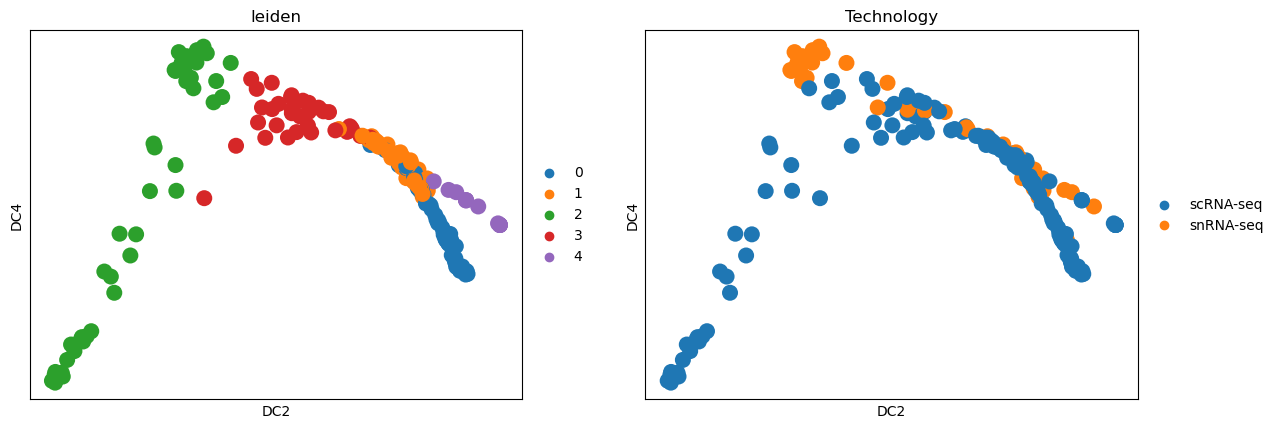

In [64]:
sc.pl.diffmap(ps_adata, color=['leiden', 'Technology'], components=['2,4'])

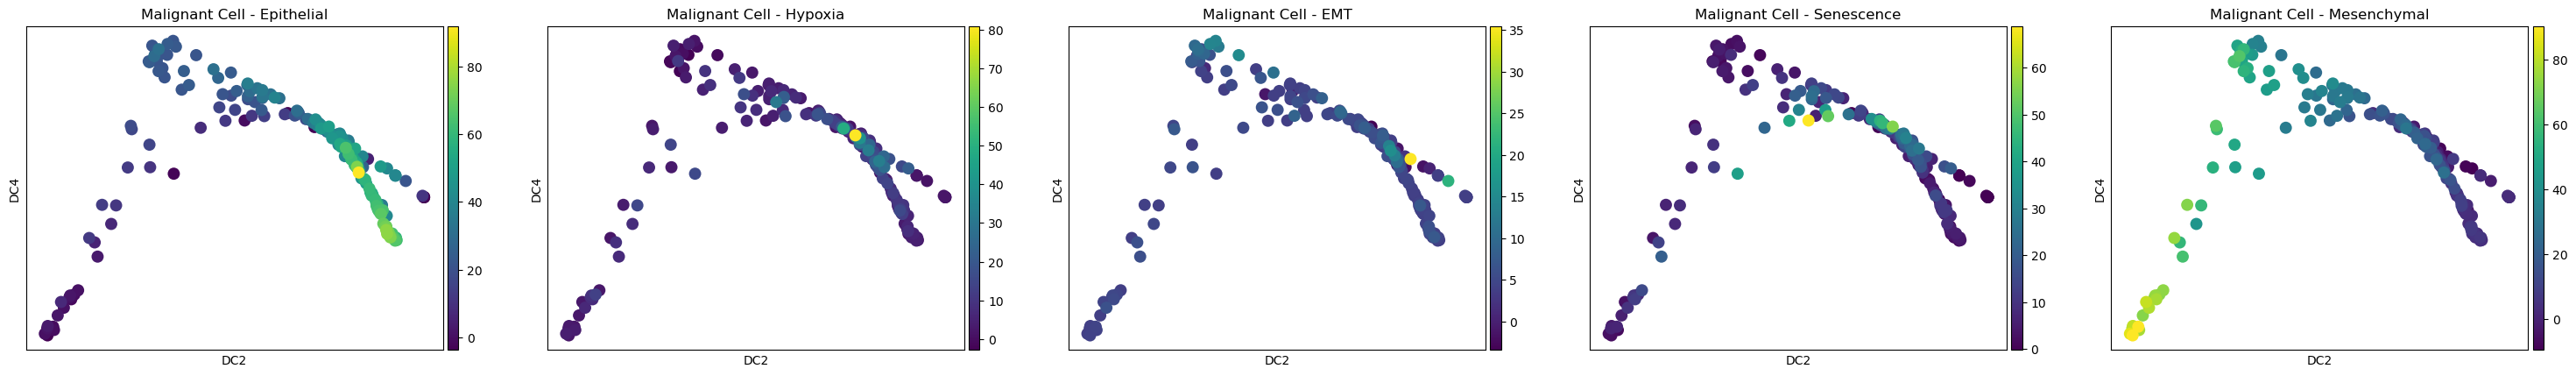

In [65]:
sc.pl.diffmap(ps_adata, color=['Malignant Cell - Epithelial','Malignant Cell - Hypoxia', 'Malignant Cell - EMT', 'Malignant Cell - Senescence', 'Malignant Cell - Mesenchymal'], components=['2,4'], size=400, ncols=5)

In [66]:
sc.pl.diffmap(ps_adata, color=['leiden'] + list(ps_adata.var_names), components=['2,4'],size=400)

In [67]:
root_index = ps_adata.obs[ps_adata.obs['TreatmentType'] == 'Untreated'].index[79]  #79 or 87
ps_adata.obs['is_root'] = ps_adata.obs.index == root_index

In [68]:
ps_adata.obs[ps_adata.obs['is_root']]

Dataset_ID   Dataset Technology  Treatment TreatmentType leiden  \
139  Lin_2020_GSM4679547  Lin_2020  scRNA-seq  Untreated     Untreated      0   

     is_root  
139     True

In [69]:
ps_adata.obs.is_root = ps_adata.obs.is_root.map({True:1, False:0})

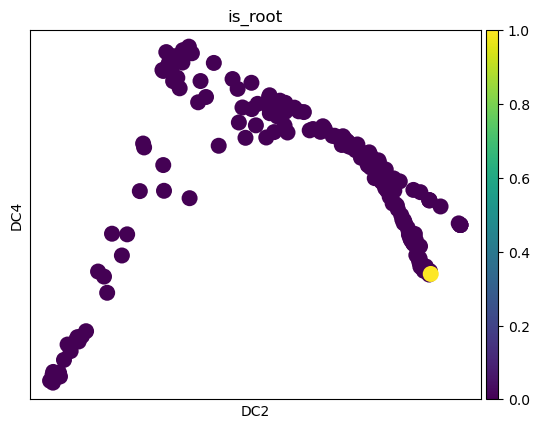

In [70]:
components=['2,4']
sc.pl.diffmap(ps_adata, color = 'is_root', groups='True', components=components)

# DPT

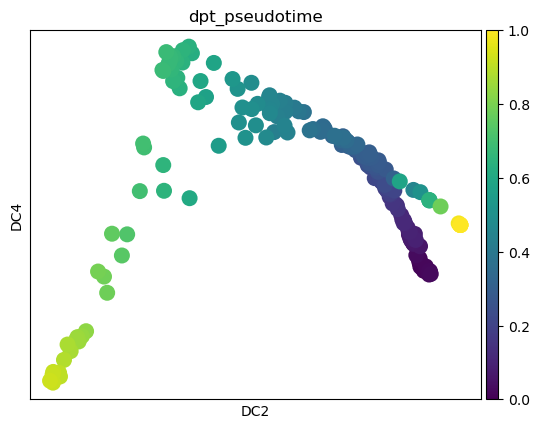

In [71]:
ps_adata.uns['iroot'] = ps_adata.obsm['X_diffmap'][:,2].argmax()
sc.tl.dpt(ps_adata, n_dcs=5)
sc.pl.diffmap(ps_adata, color = 'dpt_pseudotime', components=components)

In [234]:
ps_adata.write('ps_comp_malignant.h5ad')

In [235]:
ps_bulk_adata.write('ps_bulk_malignant.h5ad')